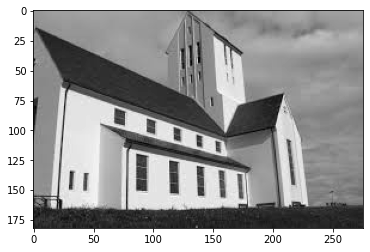

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

def grayScale(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = plt.imread("image1.jfif")
plt.imshow(img)

image1 = grayScale(img)
plt.imshow(image1, cmap = 'gray')

array([[ 72.29244857,  97.53971952, 103.25716659, ..., 112.16999098,
        106.05799572,  78.66593339],
       [ 97.28114306, 131.28625231, 139.0279758 , ..., 150.95381254,
        142.72853786, 105.86541426],
       [102.65917826, 138.51104044, 146.68705913, ..., 158.98459345,
        150.32173209, 111.49748101],
       ...,
       [ 27.10759466,  36.73131279,  41.72733564, ...,  38.96306304,
         38.86219127,  29.94937179],
       [ 26.37164433,  33.26129915,  35.42347262, ...,  33.22702831,
         33.17870516,  25.71340221],
       [ 20.26840598,  24.39362702,  24.52962519, ...,  22.47453052,
         22.4429021 ,  17.49280821]])

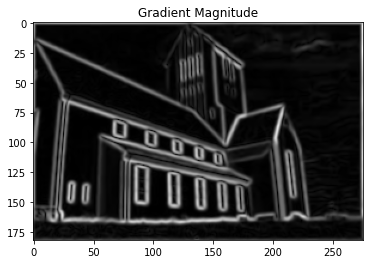

In [64]:
# function for 2D gaussian value
def gaus(x, y, sigma):
    return np.exp(-1. * ((pow(x, 2) + pow(y, 2)) / (2 * pow(sigma, 2))) )

# make Hx and Hy Kernels
def makeKernel(sigma, size):
    size = size // 2
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    
    # Gaus kernel
    kernel = gaus(x, y, sigma)
    
    # calculate Gx and Gy
    Kx = ((-1. * x) / pow(sigma, 2)) * kernel
    Ky = ((-1. * y) / pow(sigma, 2)) * kernel
    
    return Kx, Ky

# make a 2D Gaussian Kernel 
def blur(sigma, size):
    size = size // 2
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    kernel = gaus(x, y, sigma) / (2 * np.pi * pow(sigma, 2))
    return kernel

# seperate the kernel into two 1D kernels
def seperate(kernel): 
    i, j = np.unravel_index(np.abs(kernel).argmax(), kernel.shape)
    kRow = kernel[:, j, None]
    kCol = kernel[None, i, :] / kernel[i, j]
    return kRow, kCol

def convolve(img, kernel):
    # get limits
    imgX, imgY = img.shape
    kSize = kernel.shape[0]
    
    # get 1D horizontal and vertical filters
    Gx, Gy = seperate(kernel)
    
    # calculate padding
    padding = (kSize - 1) // 2 
    # make padded shape of zeros    
    padZeros = np.zeros((imgX + (2 * padding), imgY + (2 * padding)))
    # insert image into padded shape
    padZeros[padding:padZeros.shape[0] - padding, padding:padZeros.shape[1] - padding] = img
    
    # intermediate output
    temp = np.zeros_like(padZeros)
    
    # convolve rows
    for x in range(padding, imgX + padding):
        for y in range(padding, imgY + padding):
            current = np.array(padZeros[x - padding: x + padding + 1, y])
            temp[x,y] = np.dot(Gx[:,0], current)
        
    # output image
    output = np.zeros_like(img)
    
    # convolve columns
    for x in range(padding, imgX + padding):
        for y in range(padding, imgY + padding):
            current = temp[x, y - padding:y + padding + 1]
            convol = (Gy * current).sum()
            output[x - padding,y - padding] = convol
            
    
    return output
    

# constants
sigma = 1
ksize = 5

# blur image
gausK = blur(sigma, ksize) 
gX, gY = seperate(gausK)
# convolve signal
# temp = signal.convolve2d(image1, gX, mode='same')
# blurred = signal.convolve2d(temp, gY, mode='same')
# plt.imshow(temp, cmap = 'gray')
# plt.imshow(blurred, cmap = 'gray')

# my convolve
blurred = convolve(image1, gausK)
# plt.imshow(blurred, cmap = 'gray')


# make Hx and Hy
Hx, Hy = makeKernel(sigma, ksize)

# compute X and Y derivatives of image
Ix = convolve(blurred, Hx)
Iy = convolve(blurred, Hy)

# compute magnitude of the gradient at every point
gMag = np.hypot(Ix, Iy)

plt.imshow(gMag, cmap = 'gray')
plt.title("Gradient Magnitude")
blurred

Text(0.5, 1.0, 'non-max suppression')

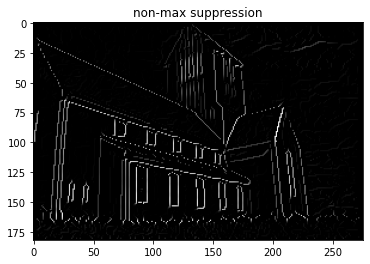

In [60]:
# non-max suppression
def suppress(gMag, gDir):
    row, col = gMag.shape
    out = np.zeros((row,col))
    
    # check gradient angles
    for i in range(1, row-1):
        for j in range(1, col-1):
            direction = gDir[i, j]
            if (0. <= direction < 22.5) or (337.5 <= direction < 360.):
                before = gMag[i, j-1]
                after = gMag[i, j+1]
            elif (22.5 <= direction < 67.5) or (202.5 <= direction < 247.5):
                before = gMag[i + 1, j - 1]
                after = gMag[i - 1, j + 1]
            elif (67.5 <= direction < 112.5) or (247.5 <= direction < 292.5):
                before = gMag[i - 1, j]
                after = gMag[i + 1, j]
            else:
                before = gMag [i-1, j-1]
                after = gMag [i+1, j+1]
            
            
            if gMag[i, j] >= before and gMag[i, j] >= after:
                out[i, j] = gMag[i, j]
                
    return out

# compute direction of gradient
gDir = np.arctan2(Ix, Iy)

suppr = suppress(gMag, gDir)
plt.imshow(suppr, cmap = 'gray')
plt.title("non-max suppression")

Text(0.5, 1.0, 'Hysteresis Thresholding')

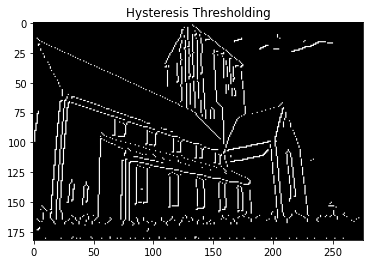

In [61]:
# Hysteresis Thresholding
def threshold(img, low, high):
    
    # adjust high and low threshold to image
    high *= img.max()
    low *= high
    
    # make new matrix
    row, col = img.shape
    out = np.zeros((row, col))
    
    # Select pixels such that M > Th
    strI, strJ = np.where(img >= high)
    zeroI, zeroJ = np.where(img < low)
    weakI, weakJ = np.where(((img < high) & (img >=low)))
    
    out[strI, strJ] = 255.
    out[zeroI, zeroJ] = 0.
    
    # Hysteresis for neighbors
    for i, j in zip(weakI, weakJ):
        if ((img[i-1, j-1] == high) or (img[i-1, j] == high) or (img[i-1, j+1] == high) or
            (img[i+1, j-1] == high) or (img[i+1, j] == high) or (img[i+1, j+1] == high) or
            (img[i, j-1] == high) or (img[i, j+1] == high)):
            img[i, j] = high   
        else:
            img[i, j] = 0
    
    return out
    
low = 0.01
high = 0.1

thres = threshold(suppr, low, high)
plt.imshow(thres, cmap = 'gray')
plt.title("Hysteresis Thresholding")

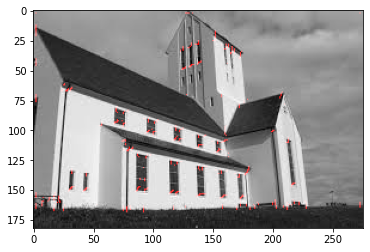

In [62]:
# Harris Corner
def findCorners(image, window, k, thresh):
    
    # color to grayscale
    img = grayScale(image)
    
    # spatial derivative calculation
    Hx, Hy = makeKernel(sigma, ksize)
    Ix = convolve(img, Hx)
    Iy = convolve(img, Hy)
    
    # strcuture tensor setup
    Ixx = pow(Ix, 2)
    Iyy = pow(Iy, 2)
    Ixy = Ix * Iy
    
    row, col = img.shape
    size = window // 2
    cornerList = np.zeros((row,col))
    
    for i in range(size, row - size):
        for j in range(size, col - size):
            # check windows
            Sxx = Ixx[i - size:i + size + 1, j - size:j + size + 1].sum()
            Syy = Iyy[i - size:i + size + 1, j - size:j + size + 1].sum()
            Sxy = Ixy[i - size:i + size + 1, j - size:j + size + 1].sum()
            
            # corner response calculation
            det = (Sxx * Syy) - pow(Sxy, 2)
            trace = Sxx + Syy
            r = det - k * pow(trace, 2)
            
            # threshold
            if r > thresh:
                cornerList[i, j] = r
    
    # non-max suppression
    corners = suppress(cornerList, gDir)
    
    # colour corners red
    output = image.copy()
    cornI, cornJ = np.where(corners != 0.)
    for i, j in zip(cornI.tolist(), cornJ.tolist()):
        output.itemset((i, j, 0), 255)

    return output

# constants
windowSize = 5
k = 0.05
threshold = pow(10, 10)

# output
colored = findCorners(img, windowSize, k, threshold)
plt.imshow(colored)